#**Data importing:**


The code snippet provided reads an Excel file named **`Practical Exercise - Interview.xlsx`** using **`pandas`** and loads the data from the sheet **`OSHA 2021 Severe Injuries`** into a DataFrame called **`df`**. This prepares the data for further analysis and processing.

In [53]:
import pandas as pd

# Reading an Excel file
df = pd.read_excel('Practical Exercise - Interview.xlsx', sheet_name='OSHA 2021 Severe Injuries')

#**Data Preparation (Data Cleaning):**

The code below explores the dataset by previewing the first few rows, checking column info, identifying missing and duplicate values, and analyzing unique values in the `Hospitalized` and `Amputation` columns. It reveals that `Hospitalized` is not binary, while `Amputation` is.

In [54]:
# Preview the data
print(df.head())

# Get general info about columns and data types
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Check for duplicate rows
print(df.duplicated().sum())

print(df['Hospitalized'].unique()) #figured out it's not just binary

print(df['Amputation'].unique()) #figured out it's binary



           ID      UPA  EventDate         City State      Zip  Latitude  \
0  2021010001  1714109 2021-01-01  WINTER PARK    CO  80482.0     39.88   
1  2021010002  1714369 2021-01-01    DEERFIELD    IL  60015.0     42.15   
2  2021010004  1714149 2021-01-01        MIAMI    FL  33144.0     25.76   
3  2021010009  1714180 2021-01-01    THIBODAUX    LA  70301.0     29.88   
4  2021010015  1714015 2021-01-02        DOVER    OH  44622.0     40.51   

   Longitude  Primary NAICS  Hospitalized  ...  Nature  \
0    -105.76         713920             1  ...     194   
1     -87.86         446110             1  ...     143   
2     -80.30         445110             1  ...    1311   
3     -90.79         444110             1  ...     111   
4     -81.45         331221             0  ...    1311   

                                         NatureTitle Part of Body  \
0  Internal injuries to organs and blood vessels ...          310   
1                                Bruises, contusions          

Decided to go with these following columns (the integer is the number of missing values)

* EventDate
* City - 2
* State
* Lat - 15
* Long - 15
* Hospitalized
* Amputation - 2
* Nature / Nature Title
* Part of body / Part of body title
* Event / Event title
* source / source title

The code snippet below fills missing city values in the dataset by using latitude and longitude coordinates. It leverages the **Geopy library** with the **Nominatim geocoder** to reverse geocode coordinates into location details. If the `City` is unavailable, it falls back to fields like `town`, `village`, or `county`. Any errors during the geocoding process are handled gracefully, ensuring the process doesn't fail.

In [55]:
!pip install geopy
from geopy.geocoders import Nominatim

# Initialize geolocator
geolocator = Nominatim(user_agent="nutrien")

# Find rows with missing cities
missing_city_rows = df[df['City'].isnull()]

# Loop through the rows with missing cities
for index, row in missing_city_rows.iterrows():
    if not pd.isnull(row['Latitude']) and not pd.isnull(row['Longitude']):
        lat, lon = row['Latitude'], row['Longitude']
        try:
            location = geolocator.reverse(f"{lat}, {lon}", language="en")
            if location:
                # Extract city, fallback to alternative fields if city is missing
                city = location.raw.get('address', {}).get('city') or \
                       location.raw.get('address', {}).get('town') or \
                       location.raw.get('address', {}).get('village') or \
                       location.raw.get('address', {}).get('county') or \
                       'Unknown'
                df.at[index, 'City'] = city
        except Exception as e:
            print(f"Error fetching city for index {index}: {e}")


The code snippet standardizes the **`City`** column by removing leading and trailing whitespace using **`str.strip()`** and converting all text to uppercase with **`str.upper()`**. This ensures consistency in city names for easier analysis and comparison.

In [56]:
df['City'] = df['City'].str.strip().str.upper()

The code provided populates missing **`Latitude`** and **`Longitude`** values by geocoding the **`City`** and **`State`** columns using the **Geopy library** with the **Nominatim geocoder**. It loops through rows with missing coordinates, retrieves latitude and longitude for the given city and state, and updates the DataFrame. Errors during geocoding are handled to avoid process interruptions.

In [57]:
!pip install geopy
from geopy.geocoders import Nominatim

# Initialize geolocator
geolocator = Nominatim(user_agent="nutrien")

# Find rows with missing Latitude and Longitude
missing_lat_lon_rows = df[df['Latitude'].isnull() | df['Longitude'].isnull()]

# Loop through the rows with missing Latitude and Longitude
for index, row in missing_lat_lon_rows.iterrows():
    if not pd.isnull(row['City']) and not pd.isnull(row['State']):
        city, state = row['City'], row['State']
        try:
            location = geolocator.geocode(f"{city}, {state}", language="en")
            if location:
                # Extract latitude and longitude
                df.at[index, 'Latitude'] = location.latitude
                df.at[index, 'Longitude'] = location.longitude
        except Exception as e:
            print(f"Error fetching lat/lon for index {index}: {e}")


The code below deduces missing **`Amputation`** values by analyzing the **`Final Narrative`** column for keywords related to amputations. A list of phrases (e.g., "amputation," "severed," "cut off") is searched using regex. If any keyword is found, the row is marked as `1` (indicating amputation); otherwise, it's marked as `0`. This approach ensures that missing values in the **`Amputation`** column are inferred based on context from the narrative text.

In [58]:
import re

# Define a function to deduce Amputation based on the Final Narrative
def deduce_amputation(narrative):
    if pd.isnull(narrative):
        return 0  # Assume no amputation if the narrative is missing
    narrative = narrative.lower()
    # Check for keywords or phrases related to amputation
    amputation_keywords = [
        "amputation", "severed", "cut off", "loss of limb",
        "lost finger", "lost toe", "hand removed", "leg removed",
        "arm removed", "finger amputation", "toe amputation"
    ]
    # Use regex to find keywords
    for keyword in amputation_keywords:
        if re.search(rf"\b{keyword}\b", narrative):
            return 1  # Amputation
    return 0  # No Amputation

# Apply the function to rows with missing Amputation values
df.loc[df['Amputation'].isnull(), 'Amputation'] = df.loc[df['Amputation'].isnull(), 'Final Narrative'].apply(deduce_amputation)


The code ensures columns are in the correct data types: `EventDate` as datetime, `Latitude`/`Longitude` as floats, `City`/`State` as strings, `Hospitalized`/`Amputation` as integers, and other numeric columns as integers, filling missing values with defaults where needed.

In [59]:
# Ensure EventDate is in datetime format
df['EventDate'] = pd.to_datetime(df['EventDate'], errors='coerce')

# Ensure Latitude and Longitude are in float format
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Ensure City and State are in string format
df['City'] = df['City'].astype(str)
df['State'] = df['State'].astype(str)

# Ensure Hospitalized and Amputation are in integer format
df['Hospitalized'] = df['Hospitalized'].fillna(0).astype(int)
df['Amputation'] = df['Amputation'].fillna(0).astype(int)

# Ensure Nature, Part of Body, Event, and Source are in integer format
df['Nature'] = pd.to_numeric(df['Nature'], errors='coerce').fillna(0).astype(int)
df['Part of Body'] = pd.to_numeric(df['Part of Body'], errors='coerce').fillna(0).astype(int)
df['Event'] = pd.to_numeric(df['Event'], errors='coerce').fillna(0).astype(int)
df['Source'] = pd.to_numeric(df['Source'], errors='coerce').fillna(0).astype(int)

# Verify the changes
print(df.dtypes)


ID                                 int64
UPA                                int64
EventDate                 datetime64[ns]
City                              object
State                             object
Zip                              float64
Latitude                         float64
Longitude                        float64
Primary NAICS                      int64
Hospitalized                       int64
Amputation                         int64
Inspection                       float64
Final Narrative                   object
Nature                             int64
NatureTitle                       object
Part of Body                       int64
Part of Body Title                object
Event                              int64
EventTitle                        object
Source                             int64
SourceTitle                       object
Secondary Source                 float64
Secondary Source Title            object
dtype: object


The code extracts `Day` (day name), `Month`, and `Year` from the `EventDate` column, adds them as new columns, and reorders the DataFrame to place these new columns immediately after `EventDate`. This improves date-based analysis and ensures logical column organization.

In [60]:
# Extract the 'Day Name', 'Month', and 'Year' columns
df['Day'] = df['EventDate'].dt.day_name()  # Day of the week as a name
df['Month'] = df['EventDate'].dt.month
df['Year'] = df['EventDate'].dt.year

# Reorder the columns to place 'Day', 'Month', and 'Year' after 'EventDate'
columns = df.columns.tolist()
event_date_index = columns.index('EventDate')  # Find the index of 'EventDate'

# Remove 'Day', 'Month', and 'Year' from the original columns list to avoid duplication
columns = [col for col in columns if col not in ['Day', 'Month', 'Year']]

# Create the new column order
new_column_order = (
    columns[:event_date_index + 1] +  # Include all columns up to 'EventDate'
    ['Day', 'Month', 'Year'] +       # Add 'Day', 'Month', and 'Year'
    columns[event_date_index + 1:]   # Include the rest of the columns
)

# Apply the new column order to the DataFrame
df = df[new_column_order]


#**Data Analysis and Visualization:**

The code creates an interactive map using **Folium**, centered on the US. It adds a **MarkerCluster** layer to group events based on their proximity. Each event is represented by a **circle marker** at its latitude and longitude, with tooltips displaying relevant details (city, state, body part affected, and cause). The map is saved as **`event_map.html`** for viewing in a browser.

In [61]:
import folium
from folium.plugins import MarkerCluster

# Create a map centered on the US
map_events = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add a MarkerCluster layer
marker_cluster = MarkerCluster().add_to(map_events)

# Add markers with tooltips for each event
for _, row in df.iterrows():
    if not pd.isnull(row['Latitude']) and not pd.isnull(row['Longitude']):
        # Tooltip text
        tooltip_text = (
            f"City: {row['City']}<br>"
            f"State: {row['State']}<br>"
            f"Body Part: {row['Part of Body Title']}<br>"
            f"Cause: {row['EventTitle']}"
        )
        # Add marker to cluster
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,  # Slightly larger for better visibility
            color='blue',
            fill=True,
            fill_opacity=0.7,
            tooltip=tooltip_text
        ).add_to(marker_cluster)

# Save map to file
map_events.save("event_map.html")


The code visualizes the **Top 5 most commonly injured body parts** using a **horizontal bar chart** created with Matplotlib and Seaborn. Each bar represents the number of incidents for a body part, styled with a blue gradient. Annotations on the bars display the exact counts, and the chart includes a title, axis labels, and a clean layout for presentation.

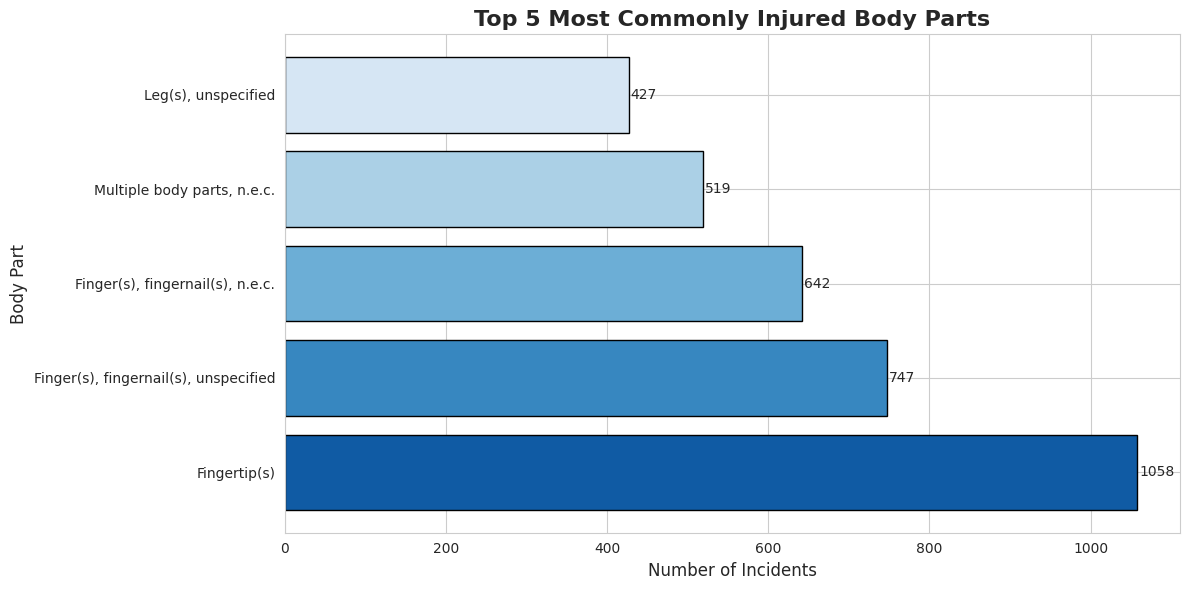

In [62]:
# Top 5 most commonly injured body parts
body_parts_counts = df['Part of Body Title'].value_counts().head(5)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the chart
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
bars = plt.barh(
    body_parts_counts.index,
    body_parts_counts.values,
    color=sns.color_palette("Blues_r", len(body_parts_counts)),
    edgecolor='black'
)

# Add title and labels
plt.title("Top 5 Most Commonly Injured Body Parts", fontsize=16, fontweight='bold')
plt.xlabel("Number of Incidents", fontsize=12)
plt.ylabel("Body Part", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add annotations on each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 2,  # Position text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        str(int(width)),
        va='center',
        ha='left',
        fontsize=10
    )

# Adjust layout and show plot
plt.tight_layout()
# plt.savefig("most_common_body_parts.png")
plt.show()


The code generates a **bar chart** to visualize the **Top 5 causes of injuries** using Matplotlib and Seaborn. It formats long labels with line wrapping for readability, applies a **"coolwarm" gradient color palette**, and includes precise annotations above each bar for clarity. The chart is styled with a white grid background, bold titles, and axis labels for a clean and professional presentation.

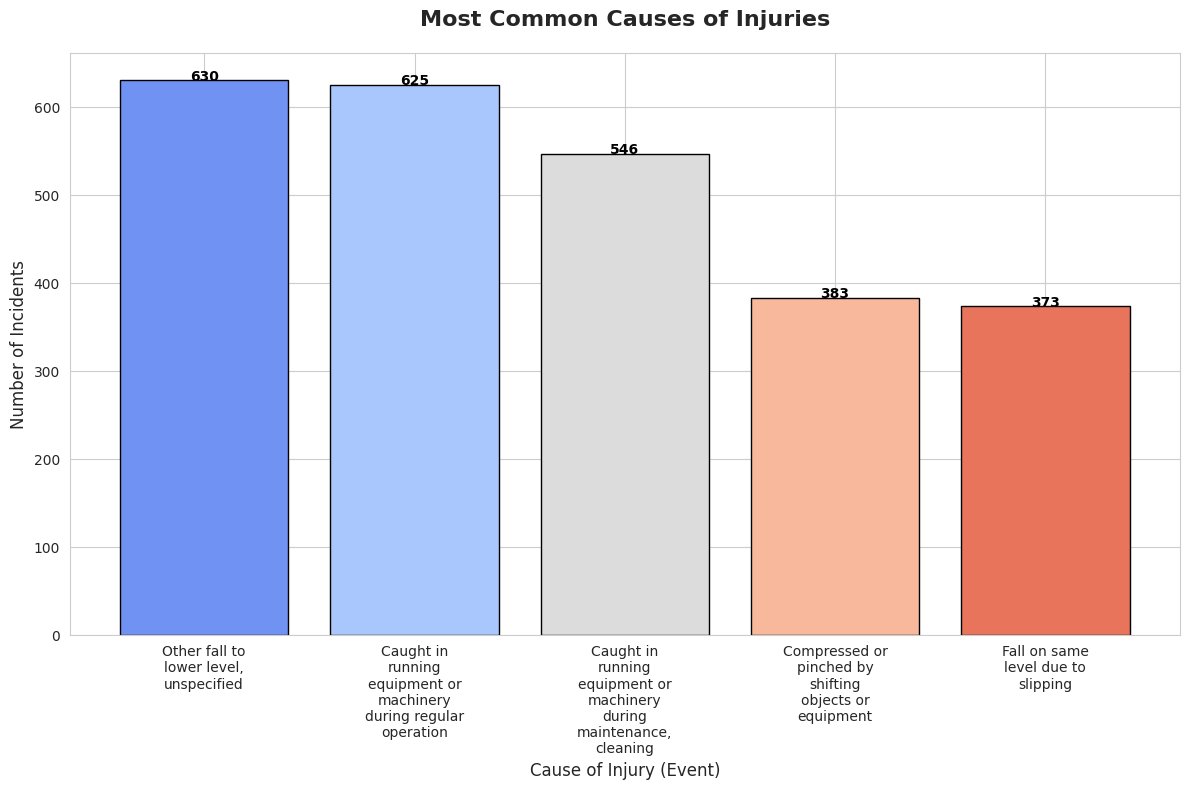

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

# Top 5 causes of injuries
top_events = df['EventTitle'].value_counts().head(5)

# Prepare data for bar chart
causes = top_events.index
frequencies = top_events.values

# Wrap text labels for better readability
wrapped_labels = ['\n'.join(wrap(cause, width=15)) for cause in causes]

# Set a style for the chart
sns.set_style("whitegrid")

# Plot Bar Chart
plt.figure(figsize=(12, 8))  # Increase height to make bars longer
bars = plt.bar(
    wrapped_labels,
    frequencies,
    color=sns.color_palette("coolwarm", len(causes)),
    edgecolor='black'
)

# Add title and labels
plt.title("Most Common Causes of Injuries", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Cause of Injury (Event)", fontsize=12)
plt.ylabel("Number of Incidents", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add annotations on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center the text on the bar
        height + 1,  # Position above the bar
        str(height),
        ha='center',
        fontsize=10,
        color='black',
        fontweight='bold'
    )

# Adjust layout and show plot
plt.tight_layout()
# plt.savefig("common_causes_bar_chart_wrapped.png")
plt.show()


The code creates a **treemap** to visualize the **Top 5 types of injuries** using the Squarify library. Each rectangle represents an injury type, sized proportionally to its frequency. Labels display the injury type and count, styled with a **green color palette** for better aesthetics. The chart includes a bold title, removes axes for a clean look, and is formatted for easy presentation.

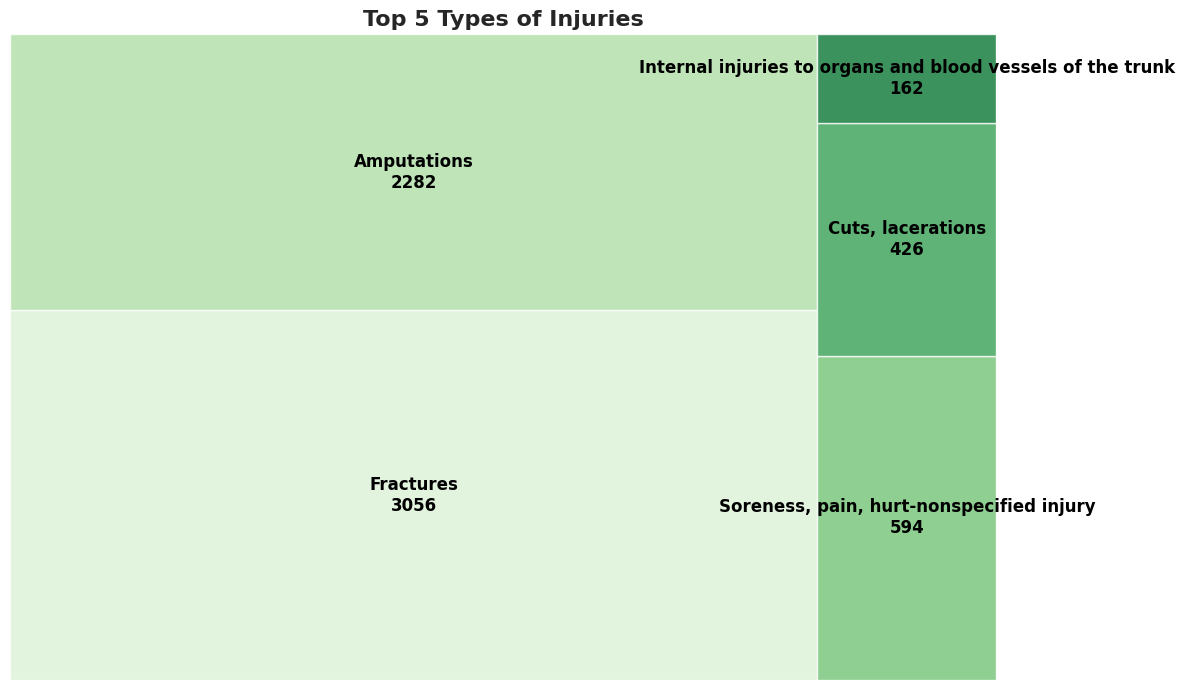

In [64]:
!pip install squarify
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# Top 5 types of injuries
injury_types_counts = df['NatureTitle'].value_counts().head(5)

# Custom color palette for better visuals
colors = sns.color_palette("Greens", len(injury_types_counts))

# Plot Treemap
plt.figure(figsize=(12, 7))
squarify.plot(
    sizes=injury_types_counts.values,
    label=[f"{label}\n{value}" for label, value in zip(injury_types_counts.index, injury_types_counts.values)],
    color=colors,
    alpha=0.8,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'color': 'black'}
)
plt.title("Top 5 Types of Injuries", fontsize=16, fontweight='bold')
plt.axis("off")
plt.tight_layout()
# plt.savefig("most_common_types_of_injury.png")
plt.show()


The code generates a **line chart** to display the **number of unique injuries over time**, grouped by `MonthYear`. It calculates the unique counts of `UPA` for each month and plots them with green markers and lines. The chart includes a bold title, labeled axes, and a grid with dashed lines for better readability, making it suitable for analyzing temporal trends in injuries.

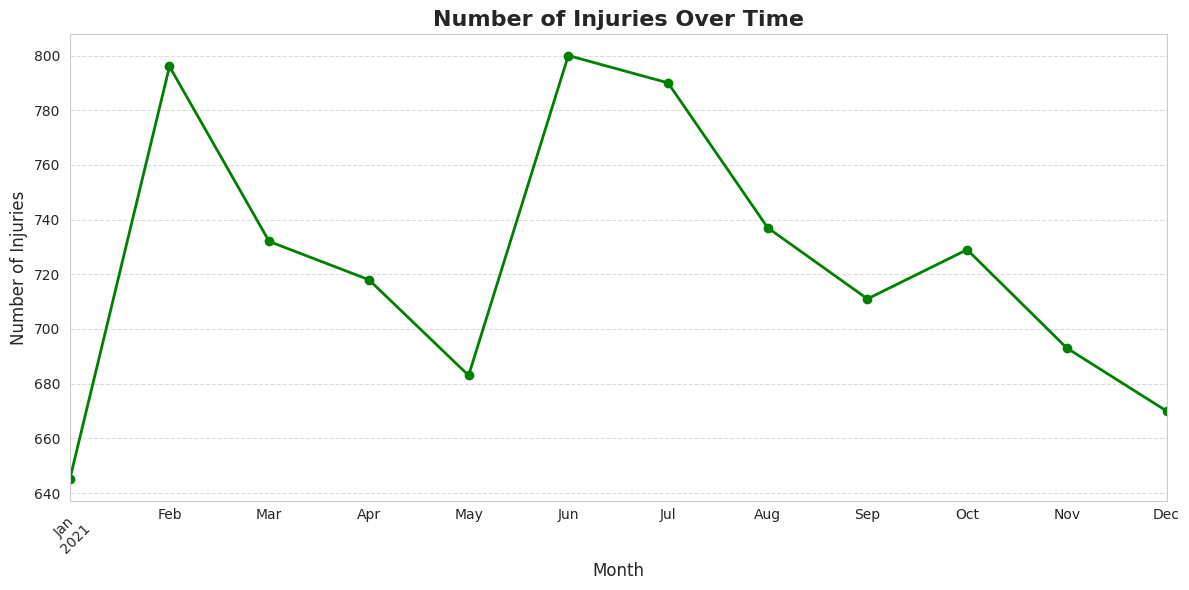

In [65]:
# Extract month and year from EventDate
df['MonthYear'] = df['EventDate'].dt.to_period('M')

# Group by MonthYear and count unique UPA values
monthly_trends = df.groupby('MonthYear')['UPA'].nunique()

# Plot
plt.figure(figsize=(12, 6))
monthly_trends.plot(kind='line', marker='o', color='green', linewidth=2)
plt.title("Number of Injuries Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Injuries", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
# plt.savefig("injuries_per_month_trendline.png")
plt.show()


The code saves the DataFrame `df` to an Excel file named **`output.xlsx`**, without including the index column, and places the data in a sheet labeled **`Sheet1`**. This is useful for exporting processed data for further use or sharing.

In [66]:
# Saving to an Excel file
df.to_excel('output.xlsx', index=False, sheet_name='Sheet1')